# Packages

In [28]:
import pandas as pd
import glob
import os
import re
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from scipy.interpolate import make_interp_spline
from plotnine import *
from matplotlib.colors import to_rgba

# Global Settings

In [29]:
# Color scheme
IMU_COLOR = '#1f77b4'  # Blue
MOCAP_COLOR = '#ff7f0e'  # Orange
DIFF_COLOR = '#2ca02c'  # Green
SPLINE_COLOR = '#d62728'  # Red
TRIAL_COLORS = plt.cm.viridis  # Colormap for trials

# Functions

## Data Cleaning

In [30]:
def parse_filename_components(df_dict):
    """Adds columns for trial number and time range extracted from filenames"""
    for name, df in df_dict.items():
        # Extract components using regular expression
        match = re.match(r'^(\d+)(.*?)_(IMU|MoCap)_(\d+s)_to_(\d+s)$', name)
        
        if match:
            # Add new columns
            df['TrialNumber'] = int(match.group(1))  # First number in filename
            df['TimeRange'] = f"{match.group(4)}-{match.group(5)}"  # Time range
            df['Duration'] = float(match.group(5).replace('s','')) - float(match.group(4).replace('s',''))
        else:
            print(f"Warning: Filename format not recognized for {name}")
            df['TrialNumber'] = None
            df['TimeRange'] = None
            df['Duration'] = None
    
    return df_dict

## Data Manipulation

In [31]:
def align_imu_mocap_data(imu_df, mocap_df):
    """
    Aligns IMU and MoCap data by:
    1. Rounding timestamps to the nearest 0.01s.
    2. Aggregating (mean) degree measures at each rounded time.
    3. Merging the two datasets on the rounded timestamps.
    4. Dropping rows with missing values.
    
    Args:
        imu_df: DataFrame containing IMU data.
        mocap_df: DataFrame containing MoCap data.
        
    Returns:
        merged_df: Aligned DataFrame with both IMU and MoCap data.
    """
    # Make copies to avoid modifying originals
    imu = imu_df.copy()
    mocap = mocap_df.copy()
    
    # Round time to nearest 0.01s
    imu['AlignedTime'] = imu['Shifted Time (s)'].round(2)
    mocap['AlignedTime'] = mocap['Time (s)'].round(2)
    
    # Aggregate (mean) degree measures at each rounded time
    imu_agg = imu.groupby('AlignedTime').agg({
        'Angle IMU (degrees)': 'mean',
        'TrialNumber': 'first',
        'TimeRange': 'first',
        'Duration': 'first',
        'Device': 'first',
        'Filename': 'first'
    }).reset_index()
    
    mocap_agg = mocap.groupby('AlignedTime').agg({
        'Angle MoCap (degrees)': 'mean',
        'TrialNumber': 'first',
        'TimeRange': 'first',
        'Duration': 'first',
        'Device': 'first',
        'Filename': 'first'
    }).reset_index()
    
    # Merge IMU and MoCap data on aligned time
    merged_df = pd.merge(
        imu_agg,
        mocap_agg,
        on=['AlignedTime', 'TrialNumber'],
        suffixes=('_IMU', '_MoCap')
    )
    
    # Drop rows where either IMU or MoCap data is missing
    merged_df = merged_df.dropna()
    
    merged_df = merged_df[['AlignedTime', 
                           'TrialNumber', 
                           'Angle IMU (degrees)', 
                           'Angle MoCap (degrees)', 
                           'Filename_IMU', 
                           'Filename_MoCap']]

    return merged_df

## Visualizations

In [32]:
def plot_all_device_data(aligned_data, motion_name, device_type='IMU'):
    """
    Plot all trials for one device type using ggplot style
    
    Args:
        aligned_data: Dictionary of aligned DataFrames
        motion_name: Name of the motion
        device_type: 'IMU' or 'MoCap'
    """
    # Combine all trials into one DataFrame
    plot_data = []
    for trial_num, df in aligned_data.items():
        temp = df[['AlignedTime', f'Angle {device_type} (degrees)']].copy()
        temp['Trial'] = f'Trial {trial_num}'
        plot_data.append(temp)
    
    combined = pd.concat(plot_data)
    combined = combined.rename(columns={
        'AlignedTime': 'Time',
        f'Angle {device_type} (degrees)': 'Angle'
    })
    
    plot = (
        ggplot(combined, aes(x='Time', y='Angle', color='Trial')) +
        geom_line(size=1, alpha=0.7) +
        labs(
            title=f'{motion_name} - All {device_type} Trials',
            x='Time (s)',
            y='Angle (degrees)'
        ) +
        theme_bw() +
        theme(
            figure_size=(12, 6),
            legend_position='right',
            legend_title=element_blank()
        )
    )
    return plot

def plot_differences_gg(aligned_data, motion_name, smooth=True):
    """
    Difference plot using ggplot-style with geom_smooth()
    """
    # Prepare difference data
    diff_data = []
    for trial_num, df in aligned_data.items():
        temp = df[['AlignedTime']].copy()
        temp['Difference'] = df['Angle MoCap (degrees)'] - df['Angle IMU (degrees)']
        temp['Trial'] = f'Trial {trial_num}'
        diff_data.append(temp)
    
    combined = pd.concat(diff_data)
    
    # Base plot
    plot = (
        ggplot(combined, aes(x='AlignedTime', y='Difference')) +
        geom_hline(yintercept=0, linetype='dashed', color='gray', alpha=0.5) +
        labs(
            title=f'{motion_name} - MoCap vs IMU Differences',
            x='Time (s)',
            y='Difference (degrees)'
        ) +
        theme_bw() +
        theme(figure_size=(12, 6))
    )
    
    if not smooth:
        # Individual trial lines with colors
        plot += geom_line(aes(color='Trial'), size=1.5, alpha=0.3)
    else:
        # Faint individual lines
        plot += geom_line(aes(group='Trial'), color='gray', size=1.5, alpha=0.15)
    
    if smooth:
        plot += geom_smooth(
            aes(group=1),  # Treat all data as one group
            method='loess',
            color='red',
            size=1.5,
            alpha=0.8,
            span=0.01,  # Controls smoothness (0-1)
            se = False
        )
    
    return plot

def plot_single_trial_comparison_gg(aligned_data, motion_name, trial_num, gap_threshold=0.1):
    """
    Single trial comparison plot with gaps for missing time values
    
    Args:
        aligned_data: Dictionary of aligned DataFrames
        motion_name: Name of the motion
        trial_num: Trial number to plot
        smooth_diff: Whether to smooth the difference line
        gap_threshold: Time difference (in seconds) that constitutes a gap
    """
    if trial_num not in aligned_data:
        raise ValueError(f"Trial {trial_num} not found")
    
    df = aligned_data[trial_num].copy()
    
    # Add gap indicators
    df = df.sort_values('AlignedTime')
    df['time_diff'] = df['AlignedTime'].diff()
    df['new_group'] = (df['time_diff'] > gap_threshold).cumsum()
    df['Difference'] = df['Angle MoCap (degrees)'] - df['Angle IMU (degrees)']
    
    # Main comparison plot with gaps
    comparison_plot = (
        ggplot(df, aes(x='AlignedTime')) +
        geom_line(aes(y='Angle IMU (degrees)', color='"IMU"', group='new_group'), size=1) +
        geom_line(aes(y='Angle MoCap (degrees)', color='"MoCap"', group='new_group'), size=1) +
        labs(title=f'{motion_name} - Trial {trial_num}') +
        scale_color_manual(values=["blue", "green"]) +
        theme_bw()
    )
    
    # Combine plots vertically
    return comparison_plot

# Data Read-in

In [33]:
# Get all csv files in the folder
folder_path = 'Aligned Data All Participants'

# Initialize separate dictionaries
axial_rotation = {}
flexion = {}
lateral_bending = {}

# Get all CSV files
all_files = glob.glob(os.path.join(folder_path, "*.csv"))

for file in all_files:
    try:
        # Get the filename without path or extension
        filename = os.path.splitext(os.path.basename(file))[0]
        
        # Read the CSV file
        df = pd.read_csv(file)

        # Add source column (IMU or MoCap)
        if 'IMU' in filename.upper():
            df['Device'] = 'IMU'
        elif 'MOCAP' in filename.upper():
            df['Device'] = 'MoCap'
        else:
            df['Device'] = 'Unknown'
            print(f"Warning: Couldn't determine source for {filename}")
        
        # Add filename as a column for reference
        df['Filename'] = filename 
        
        # Categorize based on filename
        if 'AxialRotation' in filename:
            axial_rotation[filename] = df
        elif 'Flexion' in filename:
            flexion[filename] = df
        elif 'LateralBending' in filename:
            lateral_bending[filename] = df
        else:
            print(f"File {filename} didn't match any category")
            
    except Exception as e:
        print(f"Error loading {file}: {str(e)}")

print(f"Loaded {len(axial_rotation)} AxialRotation files")
print(f"Loaded {len(flexion)} Flexion files")
print(f"Loaded {len(lateral_bending)} LateralBending files")

Loaded 52 AxialRotation files
Loaded 56 Flexion files
Loaded 54 LateralBending files


In [34]:
axial_rotation = parse_filename_components(axial_rotation)
flexion = parse_filename_components(flexion)
lateral_bending = parse_filename_components(lateral_bending)

# Time Matching

In [35]:
def process_motion(motion_dict, angle_col_name):
    """
    Processes a motion dictionary to align IMU/MoCap pairs with exact trial number matching.
    
    Args:
        motion_dict: Dictionary of DataFrames (axial_rotation, flexion, etc.)
        angle_col_name: Name of the angle column (e.g., 'AxialRotation Angle')
        
    Returns:
        Dictionary of aligned DataFrames keyed by trial number
    """
    aligned_data = {}
    
    # Create a lookup dictionary {trial_num: {device: df}}
    trial_lookup = {}
    for name, df in motion_dict.items():
        trial_num = df['TrialNumber'].iloc[0]
        device = 'IMU' if 'IMU' in name else 'MoCap'
        
        if trial_num not in trial_lookup:
            trial_lookup[trial_num] = {}
        trial_lookup[trial_num][device] = df
    
    # Process each trial
    for trial_num, devices in trial_lookup.items():
        try:
            if 'IMU' in devices and 'MoCap' in devices:
                # Standardize column names
                imu_df = devices['IMU'].rename(
                    columns={f'{angle_col_name} Angle IMU (degrees)': 'Angle IMU (degrees)'})
                mocap_df = devices['MoCap'].rename(
                    columns={f'{angle_col_name} Angle MoCap (degrees)': 'Angle MoCap (degrees)'})
                
                # Align data
                aligned_df = align_imu_mocap_data(imu_df, mocap_df)
                aligned_data[trial_num] = aligned_df
            else:
                print(f"Trial {trial_num} missing {'IMU' if 'IMU' not in devices else 'MoCap'} data")
                
        except Exception as e:
            print(f"Error processing trial {trial_num}: {str(e)}")
    
    return aligned_data

# Process all motion types
aligned_axial = process_motion(axial_rotation, 'AxialRotation')
aligned_flexion = process_motion(flexion, 'Flexion')
aligned_lateral = process_motion(lateral_bending, 'LateralBending')

# Visualizations

In [36]:
list(aligned_lateral[1].AlignedTime)

[53.01,
 53.02,
 53.03,
 53.04,
 53.05,
 53.06,
 53.08,
 53.09,
 53.1,
 53.11,
 53.12,
 53.14,
 53.15,
 53.16,
 53.17,
 53.18,
 53.19,
 53.2,
 53.21,
 53.22,
 53.23,
 53.24,
 53.25,
 53.26,
 53.27,
 53.28,
 53.29,
 53.3,
 53.31,
 53.32,
 53.33,
 53.34,
 53.35,
 53.36,
 53.37,
 53.38,
 53.39,
 53.4,
 53.41,
 53.42,
 53.43,
 53.44,
 53.45,
 53.46,
 53.47,
 53.48,
 53.49,
 53.5,
 53.51,
 53.52,
 53.53,
 53.54,
 53.55,
 53.56,
 53.57,
 53.58,
 53.59,
 53.6,
 53.61,
 53.62,
 53.63,
 53.64,
 53.65,
 53.66,
 53.67,
 53.68,
 53.69,
 53.7,
 53.71,
 53.72,
 53.73,
 53.74,
 53.75,
 53.76,
 53.77,
 53.78,
 53.8,
 53.81,
 53.82,
 53.84,
 53.86,
 53.88,
 53.89,
 53.9,
 53.91,
 53.92,
 53.93,
 53.94,
 53.95,
 53.96,
 53.97,
 53.98,
 53.99,
 54.0,
 54.01,
 54.02,
 54.03,
 54.04,
 54.05,
 54.06,
 54.07,
 54.08,
 54.09,
 54.1,
 54.11,
 54.12,
 54.13,
 54.14,
 54.15,
 54.16,
 54.17,
 54.18,
 54.19,
 54.2,
 54.21,
 54.22,
 54.23,
 54.24,
 54.25,
 54.26,
 54.27,
 54.28,
 54.29,
 54.3,
 54.31,
 54.32,
 54.3

In [ ]:
p = plot_single_trial_comparison_gg(aligned_axial, 'Axial Rotation', 14)
p.show()

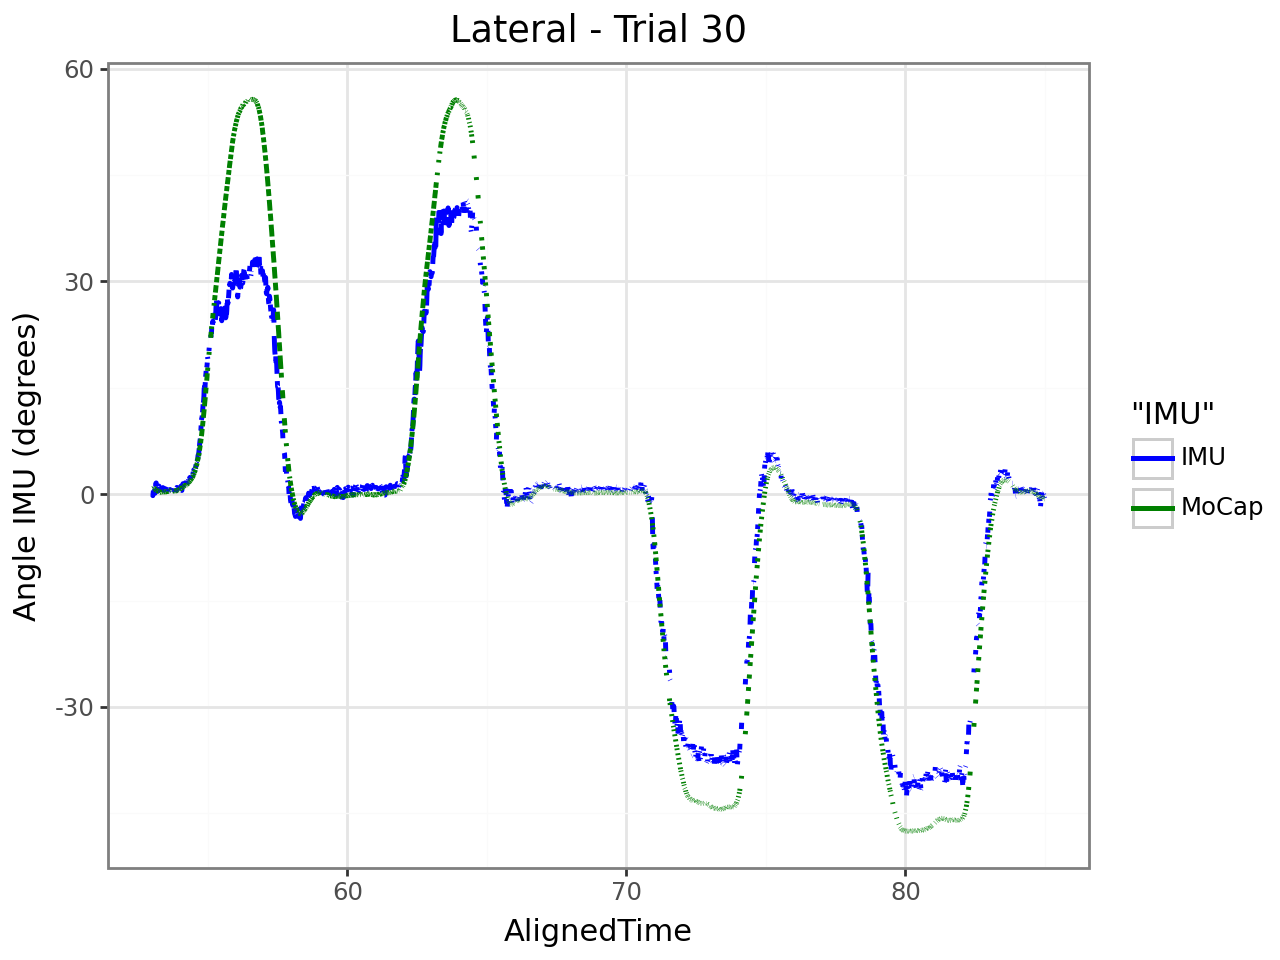

In [ ]:
p = plot_single_trial_comparison_gg(aligned_lateral, 'Lateral', 30)
p.show()

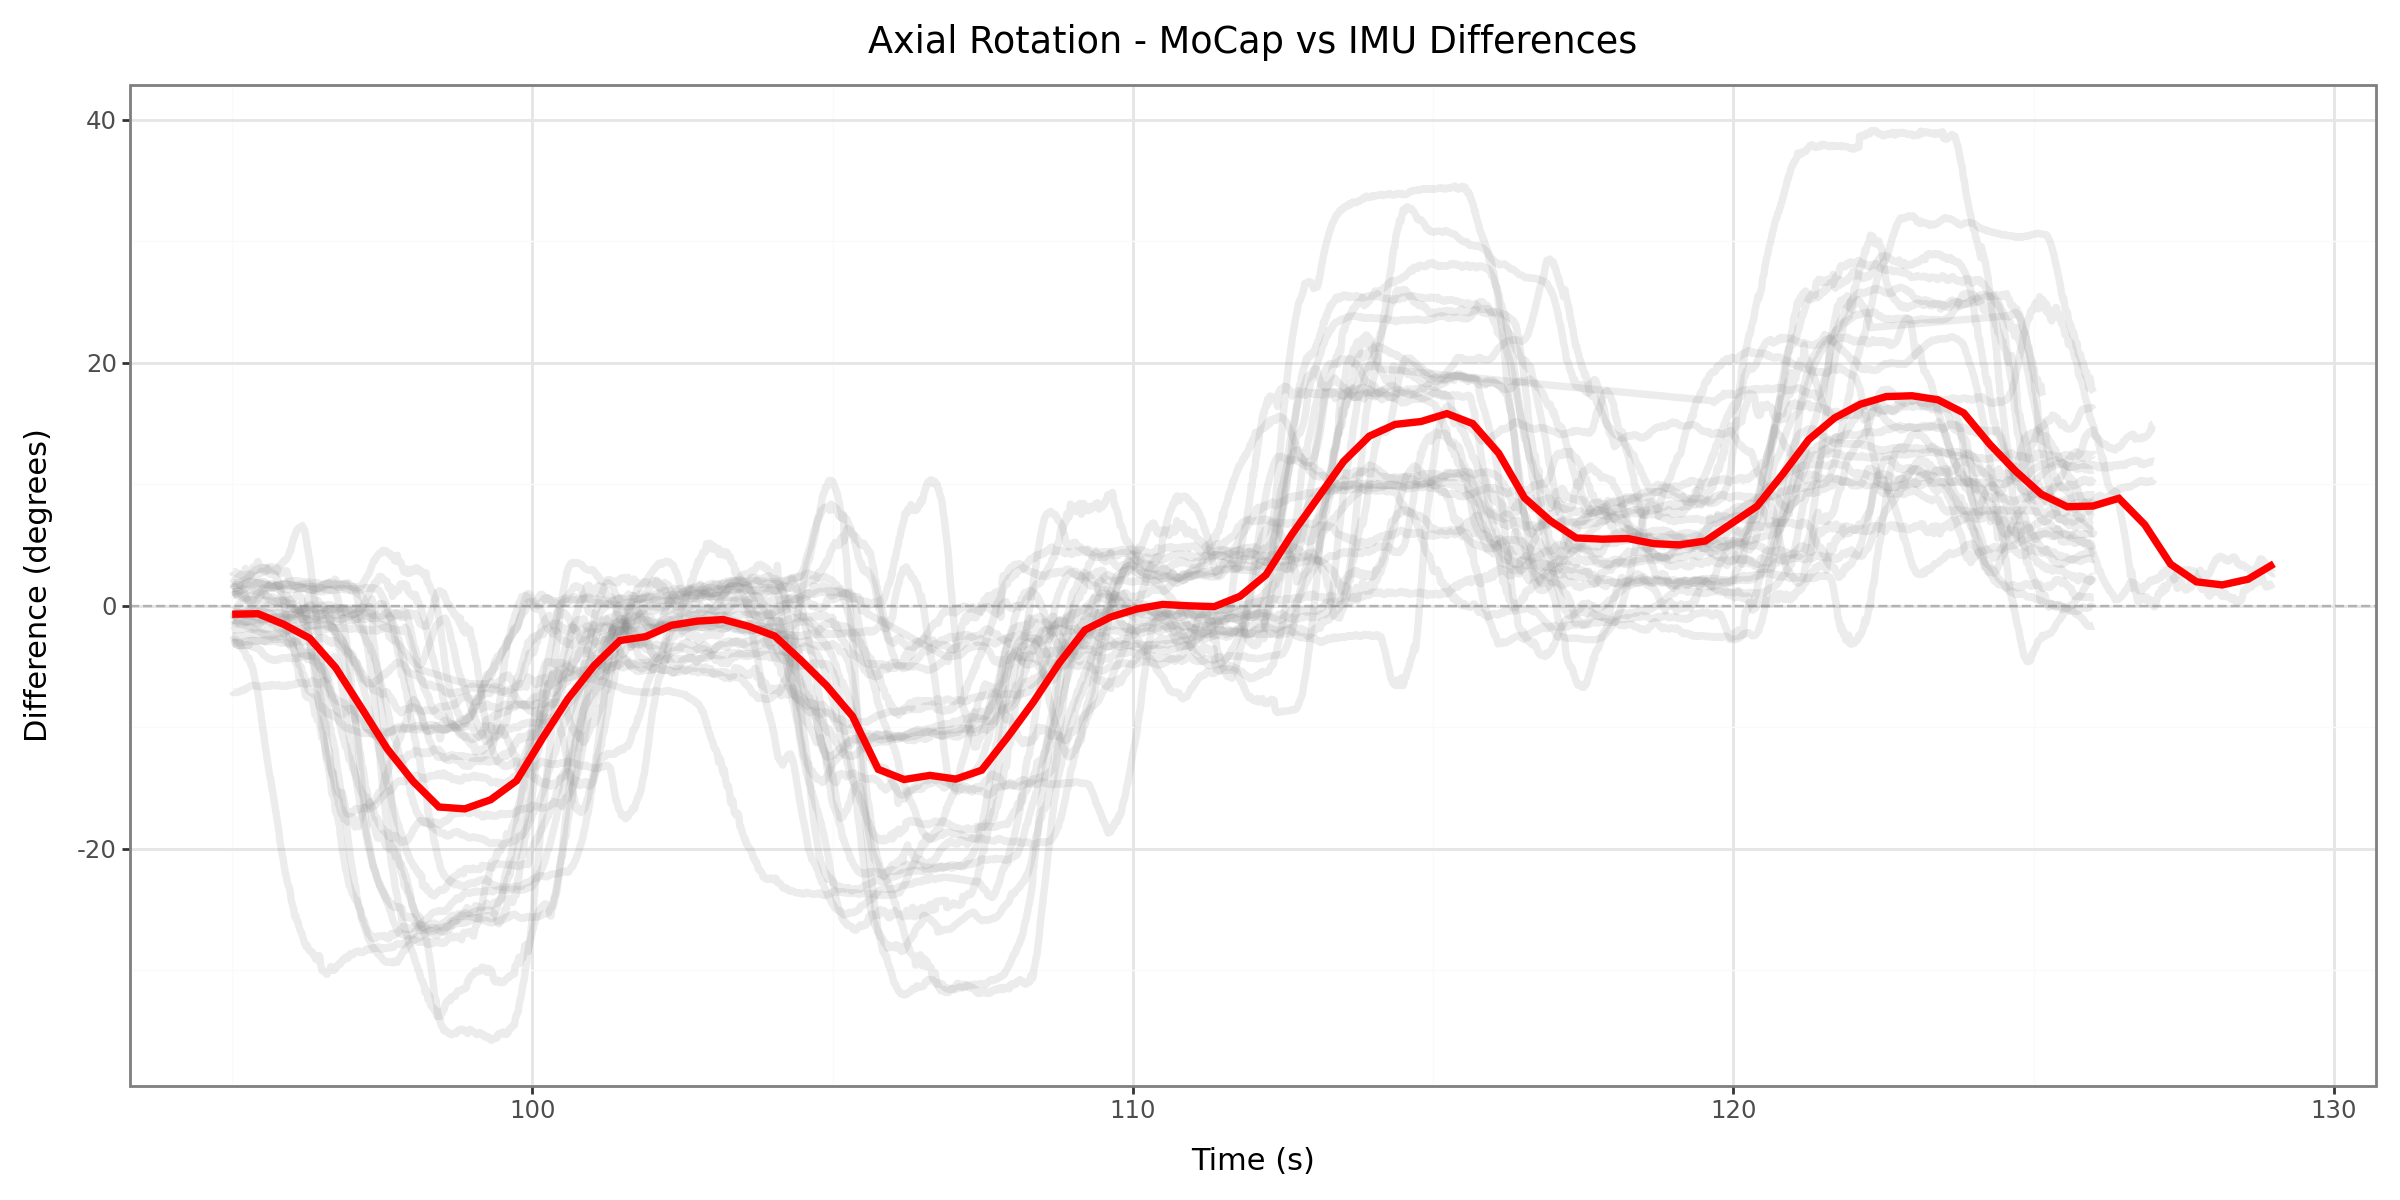

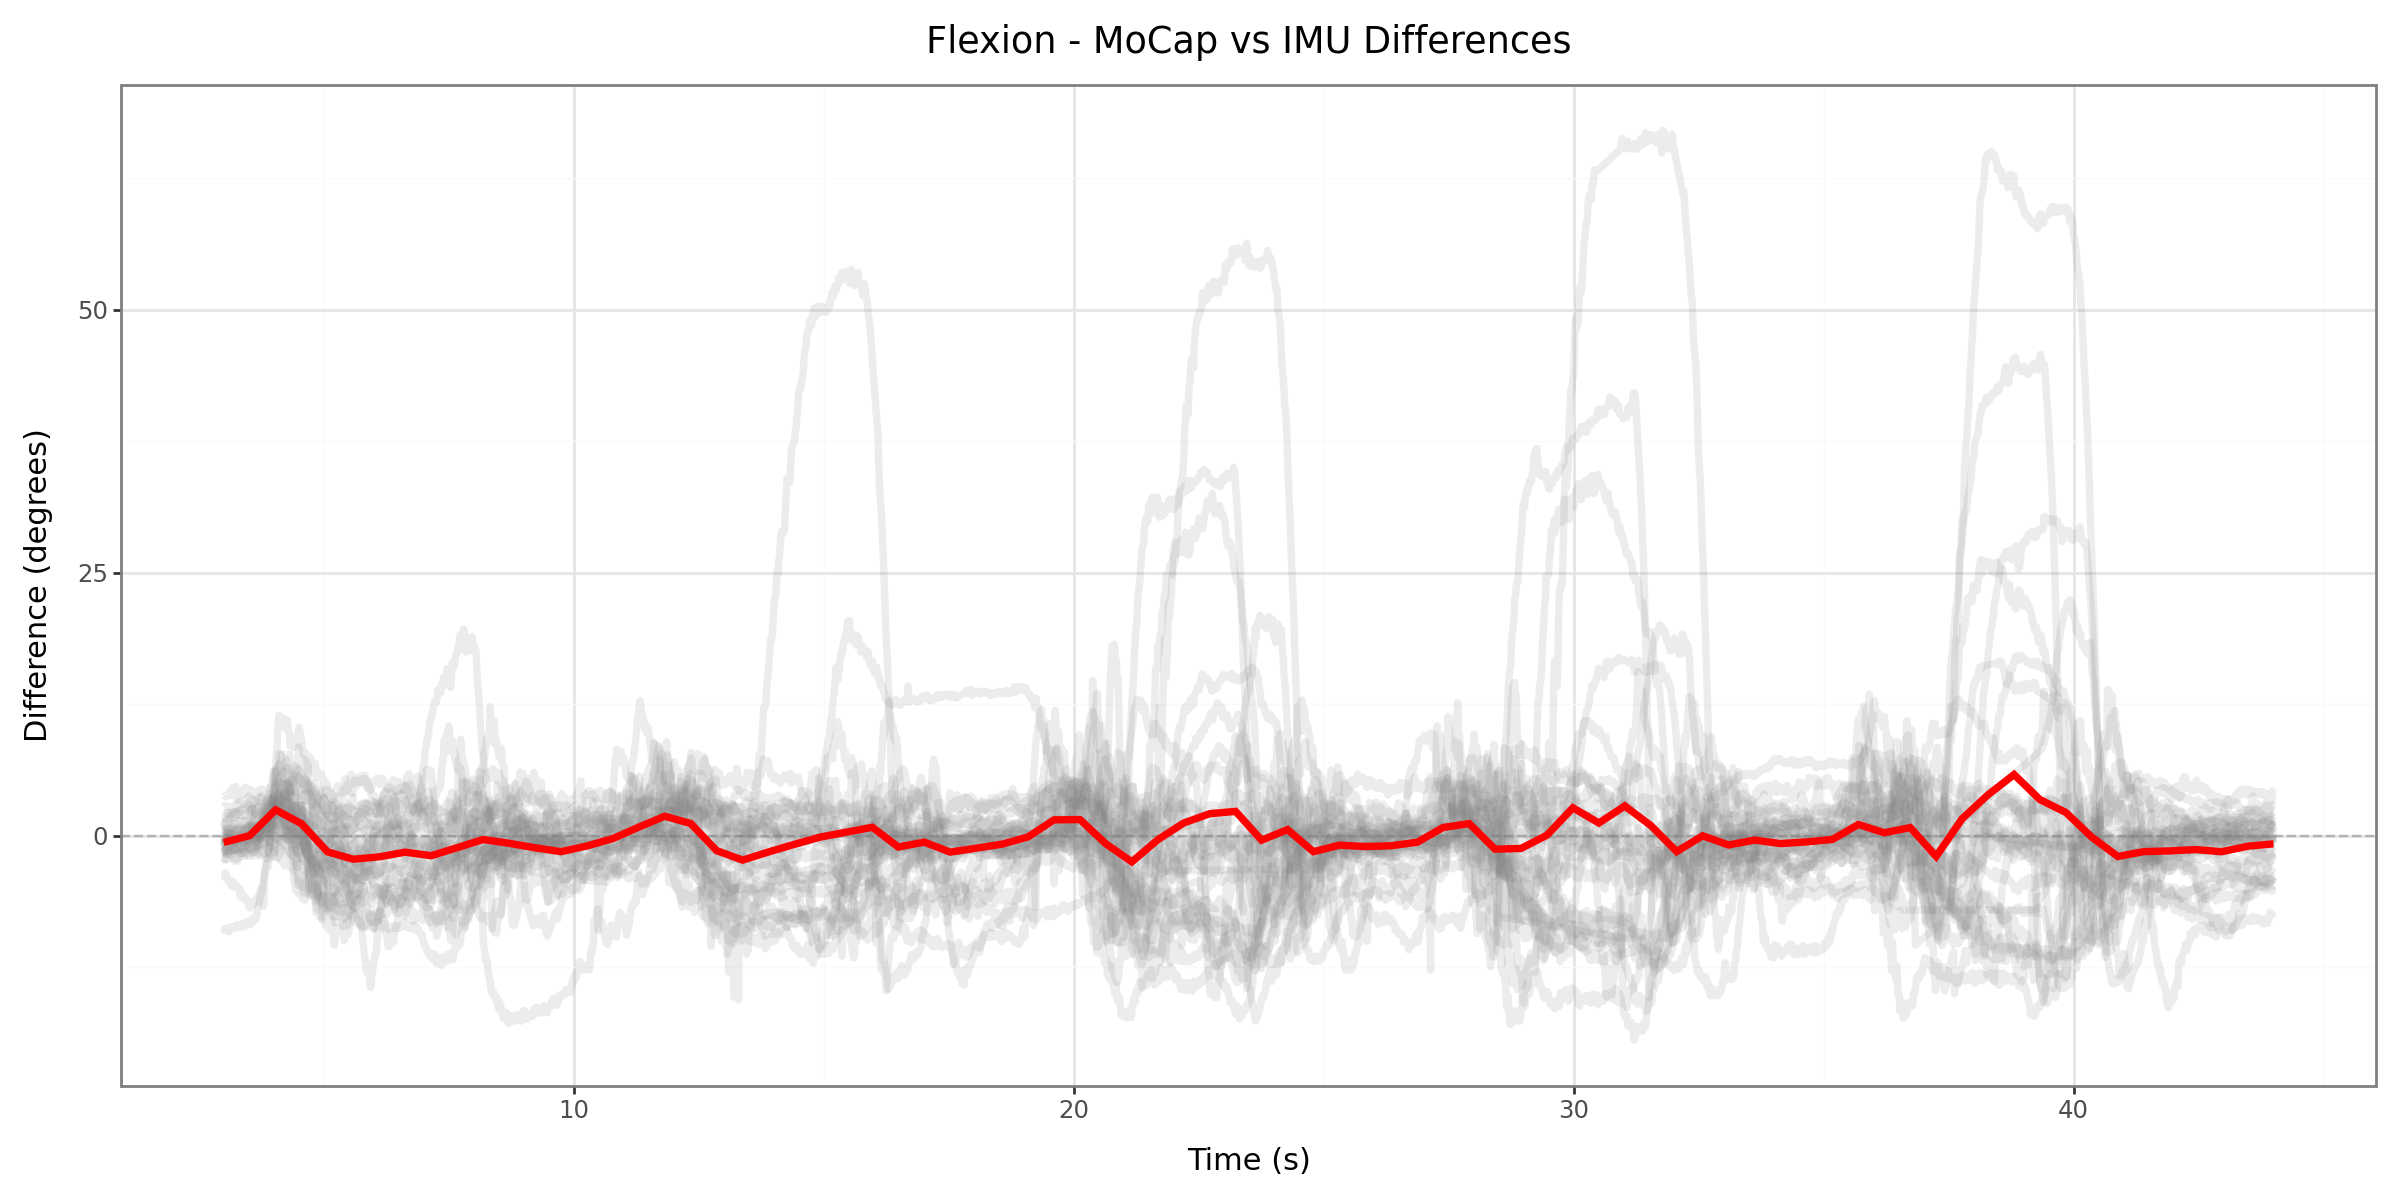

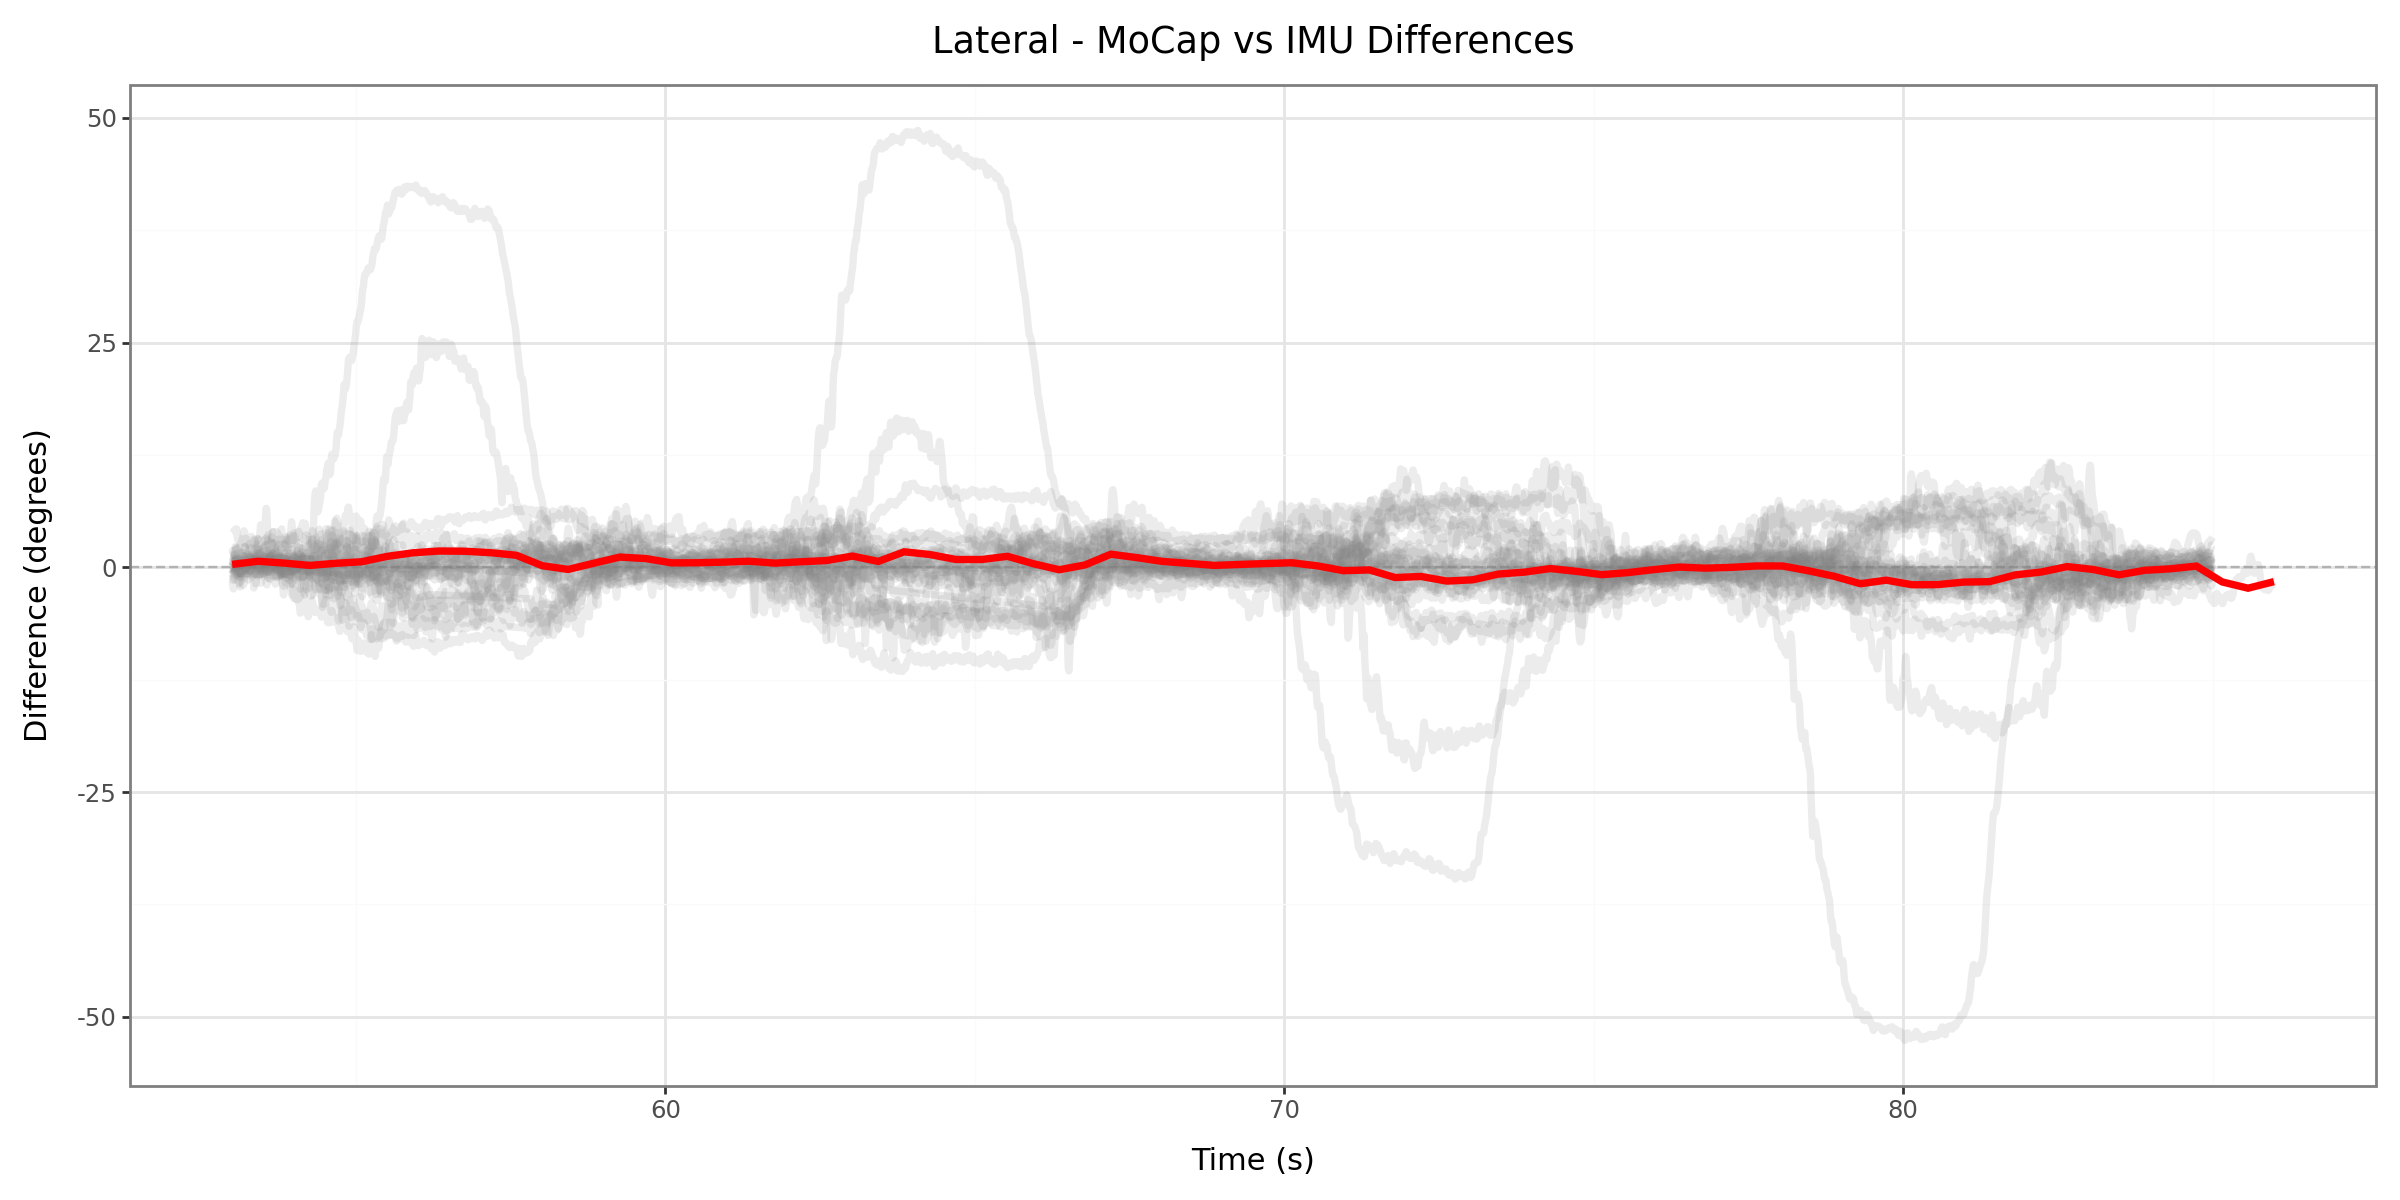

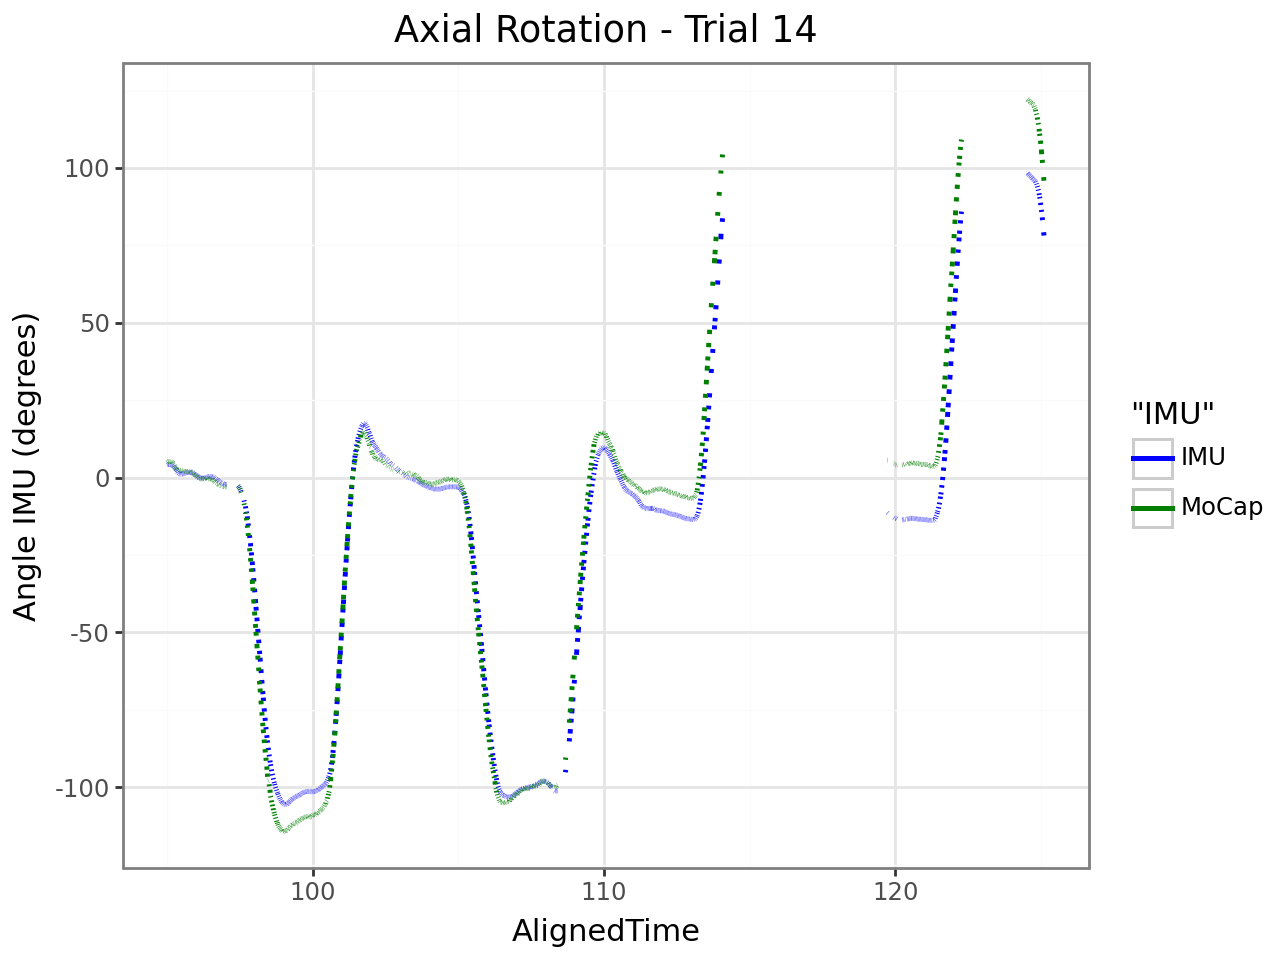

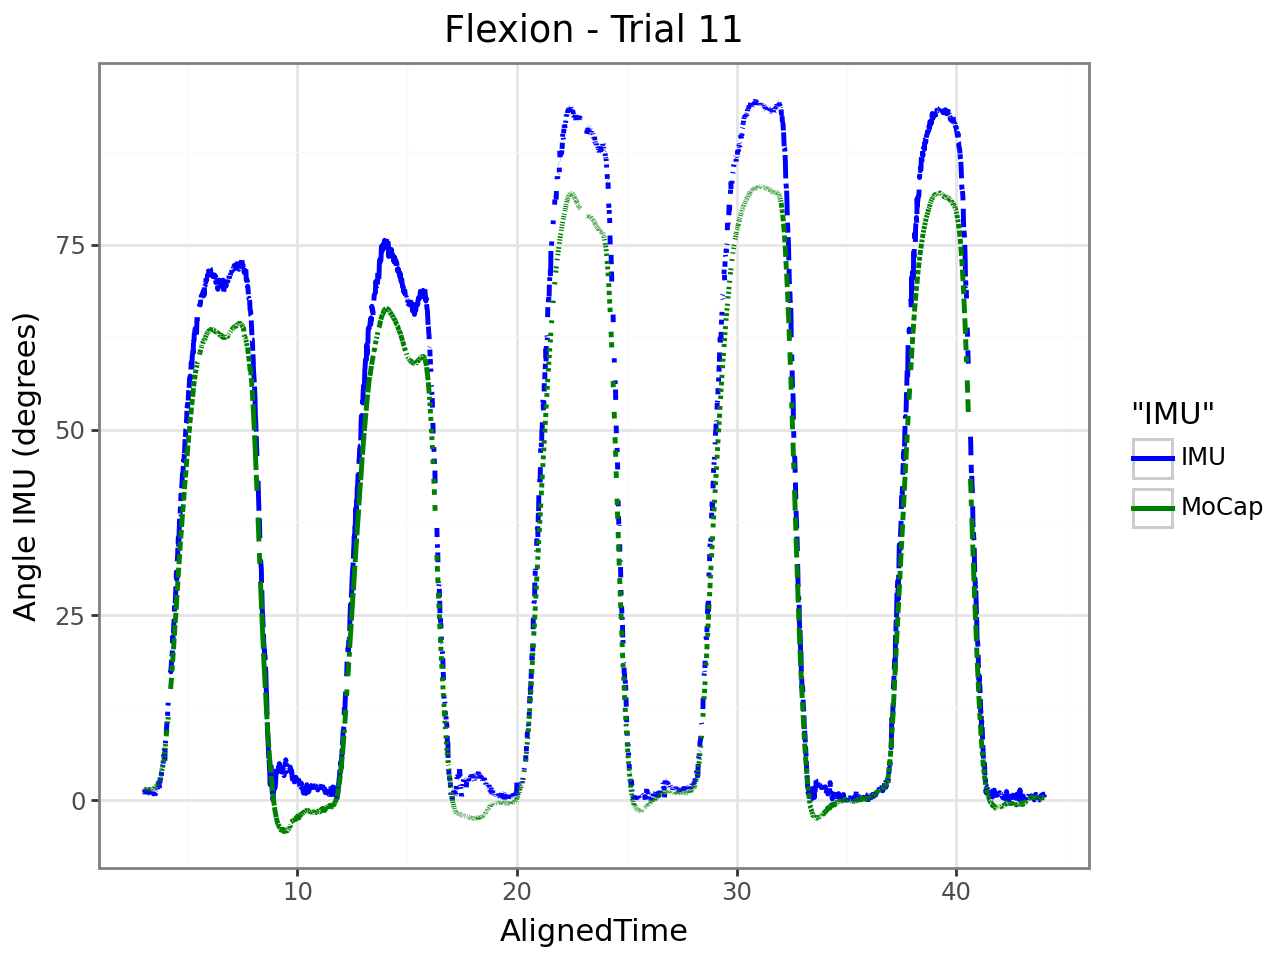

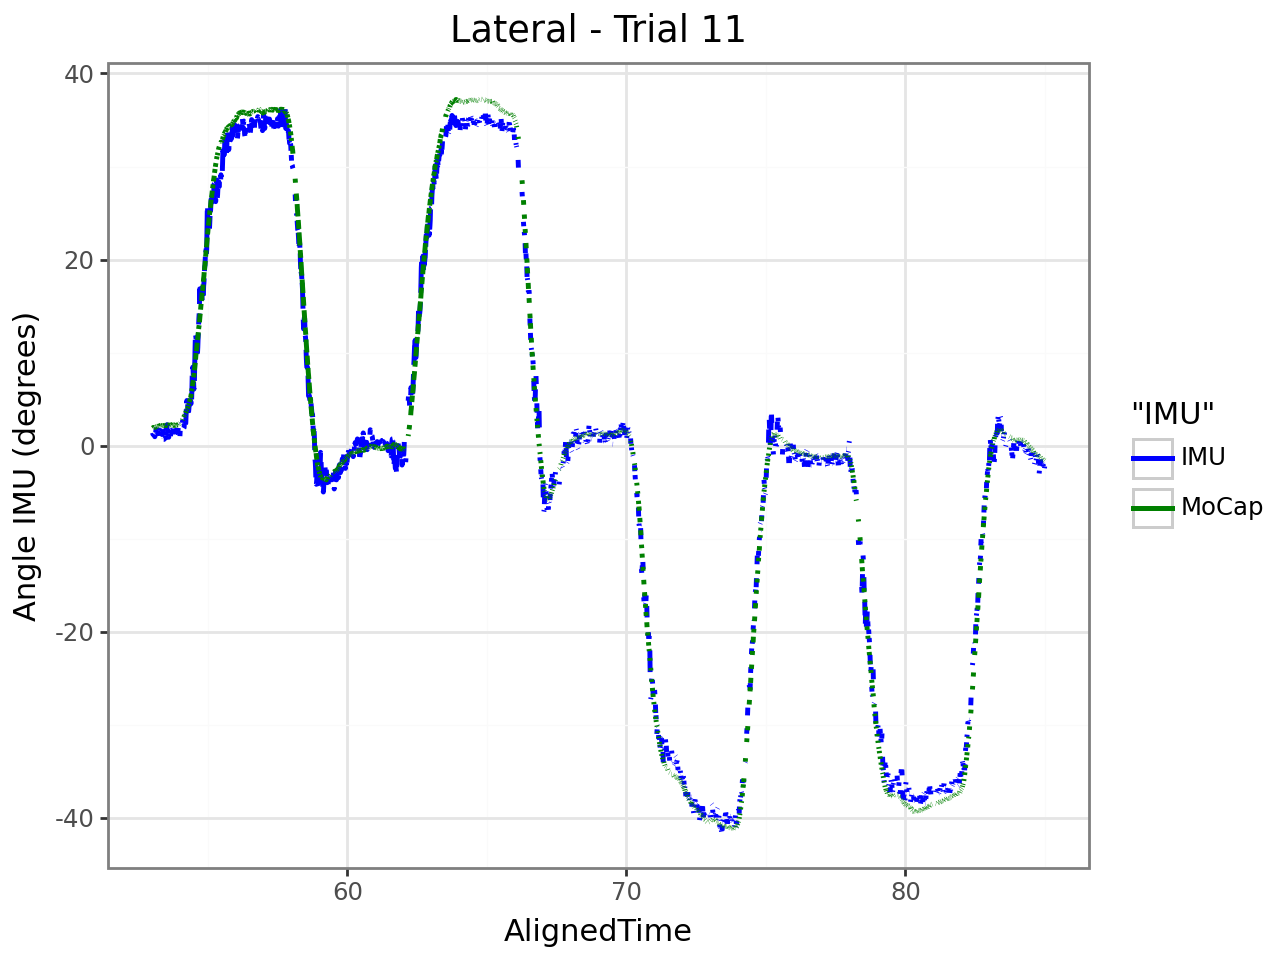

In [ ]:
# Plot differences with LOESS smoothing
p = plot_differences_gg(aligned_axial, 'Axial Rotation', smooth=True)
p.show()

p = plot_differences_gg(aligned_flexion, 'Flexion', smooth=True)
p.show()

p = plot_differences_gg(aligned_lateral, 'Lateral', smooth=True)
p.show()

# Single trial plot with/without smoothing
p = plot_single_trial_comparison_gg(aligned_axial, 'Axial Rotation', 14)
p.show()

p = plot_single_trial_comparison_gg(aligned_flexion, 'Flexion', 11)
p.show()

p = plot_single_trial_comparison_gg(aligned_lateral, 'Lateral', 11)
p.show()